# New Section

<b>
<p dir="rtl">
CA3
<p dir="rtl">
سودابه محمدهاشمی
810197688

<p dir="rtl">
مقدمه</b>

<p dir="rtl">
در این پروژه قصد داریم با استفاده از navie bayes classifier 
به تجزیه و تحلیل کتاب‌ها و موضوعات آن‌ها بپردازیم
 .


In [77]:
!pip install hazm

from hazm import *
from math import log
import numpy as np
import pandas
import time
import matplotlib.pyplot as plt

In [78]:
ENT_freq_dict={}
novel_freq_dict={}
eslam_freq_dict={}
story_freq_dict={}
social_freq_dict={}
shortStory_freq_dict={}
classes = ['مدیریت و کسب و کار','رمان','کلیات اسلام','داستان کودک و نوجوانان','جامعه‌شناسی','داستان کوتاه']
arr_freq = [ENT_freq_dict, novel_freq_dict, eslam_freq_dict, story_freq_dict, social_freq_dict, shortStory_freq_dict]

normalizer=Normalizer()
word_tokenizer=WordTokenizer()
lemmatizer=Lemmatizer()
#stemmer=Stemmer()

stop_set=set(stopwords_list()+['.','،','؛','[',']','{','}','(',')','?','!',':','\"','\'','*','/','+','%','#','-','_','\r\n','\n','«','»','۹','۸','۷','۶','۵','۴','۳','۲','۱','۰'])

train=pandas.read_csv('books_train.csv',encoding='UTF-8')
test=pandas.read_csv('books_test.csv',encoding='UTF-8')

<p dir="rtl">
<b>فاز اول: پیش پردازش داده</b>

<p dir="rtl">
دو فایل در اختیار داریم یکی برای آموزش و دیگری برای ارزیابی مدل است.
داده‌های خام آموزشی و همچنین تست را پیش‌ پردازش می‌کنیم. به این صورت که ابتدا ایست واژه‌ها، کاراکترهای بی‌اهمیت و علایم نگارشی را از جملات حذف می‌کنیم سپس با کمک کتابخانه هضم جملات نرمال می‌شوند یعنی نیم‌فاصله‌ها و فاصله‌ها اصلاح می‌شوند. سپس جملات کلمه به کلمه شکسته می‌شوند تا بتوان هر کلمه را مستقل بررسی کرد. سپس کلمات ریشه‌یابی می‌شوند.
ایست واژه‌ها کلمات پرتکراری هستند که در تمام انواع متن‌ها کاربرد دارند اما ارزش آموزش ندارند مانند انواع ضمیرها، افعال، کلمات ربط و ... .
این عملیات را جداگانه روی هر دو ستون title و description انجام می‌دهم.

<p dir="rtl">
سوال یک:
<p dir="rtl">
در متون کلمات ممکن است در اشکال مختلفی ظاهر شوند در صورتی که ریشه همگی یکسان است و می‌توان در آموزش در یک دسنه در نظر گرفت. برای این کار از
stemming and lemmatization
استفاده می‌کنیم. stemming با حذف پسوندها و پیشوندها و بدون توجه به معنی به ریشه کلمات می‌رسد اما روش lemmatization علاوه بر حذف پسوند و پیشوند، کلمه نهایی را از نظر معنا و اعتبار چک می‌کند.
از میان این دو روش lemmatization عملکرد بهتری داشت و دقت را افزایش می‌داد.

In [79]:
def PreProccessText(text):
    text=normalizer.normalize(text)
    text=word_tokenizer.tokenize(text)
    words=[lemmatizer.lemmatize(word) for word in text if not(word in stop_set)]
    #words=[stemmer.stem(word) for word in text if not(word in stop_set)]
    return words
  

def PreProccess(dataset):
    for i in range(len(dataset)):
        dataset['title'][i]=PreProccessText(dataset['title'][i])
        dataset['description'][i]=PreProccessText(dataset['description'][i])
    return dataset


def NoPreProccess(dataset):
    for i in range(len(dataset)):
        dataset['title'][i]=dataset['title'][i].split()
        dataset['description'][i]=dataset['description'][i].split()
    return dataset

In [80]:
train=PreProccess(train)
train

,title,description,categories
0,"[ساختار, نظریه, جامعه‌شناس, ایران]","[ساختار, نظریه, جامعه‌شناس, ایران, نوشته, ابوا...",جامعه‌شناسی
1,"[جامعه, فرهنگ, کانادا]","[جامعه, فرهنگ, کانادا, مجموعه, کتاب, جامعه, فر...",جامعه‌شناسی
2,"[پرسش, موعود]","[پرسش, مختلف, زندگی, شخصیت, امام, مهدی, عج, اذ...",کلیات اسلام
3,"[موج, دریا]","[موج, دریا, قلم, مهر, ماهوت, ۱۳۴۰, تصویرگر, عا...",داستان کودک و نوجوانان
4,"[پرسش, غرب]","[پرسش, غرب, قلم, دکتر, اسماعیل, شفیع, سروستان,...",جامعه‌شناسی
...,...,...,...
2545,"[قضاوت‌‏های, امیرمؤمنان, حضرت, علی, علیه‏‌السلام]","[عنوان, قضاوت, امیرمؤمنان, حضرت, علی, علیه‌الس...",کلیات اسلام
2546,"[کرامات, مهدی, موعود, عج]","[زینب, محمود, پژوهشگر, دین, پیشگفتار, کتاب, خو...",کلیات اسلام
2547,"[انتقام, انتقام, انتقام]","[انتقام, انتقام, انتقام, داستان‌گونه‌ای, زبان,...",داستان کوتاه
2548,[مرد],"[مرد, قلم, سیده‌فاطمه, موسوی, تصویرگر, جعفر, ب...",داستان کودک و نوجوانان


In [81]:
test_a=PreProccess(test)
test_a

,title,description,categories
0,[کآشوب],"[کآشوب, بیست, روایت, روضه, زندگی, همت, نفیسه, ...",داستان کوتاه
1,"[داستان, برق‌آسا]","[داستان, برق‌آسا, نام, مجموعه, داستان, گردآوری...",داستان کوتاه
2,"[بحث, مرجعیت, روحانیت]","[مجموعه, مقالات, بحث, مرجعیت, روحانیت, مقالات,...",کلیات اسلام
3,"[قلعه, حیوانات]","[قلعه, حیوانات, جورج, اورول, حیوانات, اهل, اقد...",رمان
4,[قصه],"[قصه, مجموعه, کتاب, جلد, محمد, میرکیانی, ۱۳۳۷,...",داستان کودک و نوجوانان
...,...,...,...
445,"[سیره, اقتصاد, امام, علی]","[سیره, اقتصاد, امام, علی, نوشته, سید, رضا, حسی...",کلیات اسلام
446,"[تفنگ, پدر, بام, تهران]","[بام, رفت#رو, بام, رسید#رس, همانجا, خیابان, شل...",رمان
447,[اصالت],"[اصالت, نوشته, داریوش, قاسم, دستجردی, ۱۳۳۹, نو...",جامعه‌شناسی
448,"[تأمین, مالی, آموزش, پرورش, ایران]","[تأمین, مالی, آموزش, پرورش, عموم, فرآیند, وسیل...",جامعه‌شناسی


<p dir="rtl">
<b> فاز دوم: فرایند مسئله </b>

<p dir="rtl">
در اینجا از روش bag of words استفاده می‌کنیم. برای هر کلاس به طور مجزا  کلماتی که در tilte و description مربوط به آن کلاس و تعداد تکرارشان را ذخیره می‌کنیم.

<p dir="rtl">
در تابع classify برای هر سظر از فایل تست میزان احتمال تعلق آن داده به هر کلاس را حساب می‌کنیم. به این صورت که طبق قائده بیزین احتمال هر کلمه از ستون‌ها را به شرط تعلق به کلاس مورد نظر به دست آورده و در هم ضرب می‌کنیم.
 داده متعلق به کلاسی است که احتمال بیشتری دارد. 
 این حدس‌ها را در predicted_categories نگهداری می‌کنیم تا بعدا با categoryهای داده شده مقایسه شوند.

 <p dir="rtl">
 توجه کنید که در اینجا فرض اساسی برای استفاده از قائده بیزین استقلال  احتمال تعلق هر یک از کلمات به هر دسته نسبت به کلمات دیگر است.

 <p dir="rtl">
 به جای ضرب احتمال‌ها برای دقت بیشتر لگاریتم احتمال‌ها را حساب می‌کنم و روی آن‌ها جمع می‌زنم.

 <p dir="rtl">
 سوال دو:
 <p dir="rtl">
  evidence: شاهدی است که با علم به آن می‌خواهیم احتمال posterior را حساب کنیم.
<p dir="rtl">
psterior: احتمال آن که واژه x در کلاس c قرار گیرد. با استفاده از این احتمال classify را انجام می‌دهیم و برای تمام واژه‌های یک متن محاسبه کرده و کلاس با بیشترین امتیاز را به عنوان کلاس این متن پیش‌بینی می‌کنیم.
<p dir="rtl">
likehood: احتمال آن که با دانستن کلاس c، کلمه x در این کلاس قرار دارد. احتمال آمدن evidence در کلاس c.
<p dir="rtl">
prior: احتمال وجود کلاس c با توجه به تعداد کل ردیف‌های دیتای ورودی.

<p dir="rtl">
سوال سه:
<p dir="rtl">
1.   شیر مایع سفید رنگی است.
2.   شیر حیوان درنده‌ای است.
<p dir="rtl">
در دو جمله بالا کلمه شیر معانی متفاوتی دارد. اگر از bigram استفاده کنیم با توجه به فقط یک واژه بعد از شیر می‌توان متوجه شد منظور کدام شیر است.
<p dir="rtl">
در این مثال گفته شده bigram کافی است. اما اگر کلمه بعد از شیر طوری باشد که به تنهایی به تشخیص معنا کمک نکند به n-gramهای طولانی‌تری نیاز خواهیم داشت.

<p dir="rtl">
سوال چهار:
<p dir="rtl">
اگر کلمه x از متن تست در مجموعه داده‌های آموزشی کلاس c نیامده باشد احتمال تعلق آن کلمه به کلاس c صفر می‌شود درو واقع likelihood برای آن کلاس صفر می‌شود. با توجه به navie bayes احتمال‌های کلمات متن را درهم ضرب می‌کنیم پس احتمال تعلق آن متن به کلاس c صفر می‌شود. 

<p dir="rtl">
سوال پنج:
<p dir="rtl">
برای حل این مشکل از addictive smoothing استفاده می‌کنیم. با دیدن یک واژه کاملا جدید x برای یک کلاس c، فرض می‌گیریم به احتمال کمی کلمه x متعلق به کلاس c است. این احتمال از احتمال کلمات موجود در مجموعه داده‌ی کلاس c کمتر است.
برای این کار از فرمول زیر استفاده می‌کنیم.

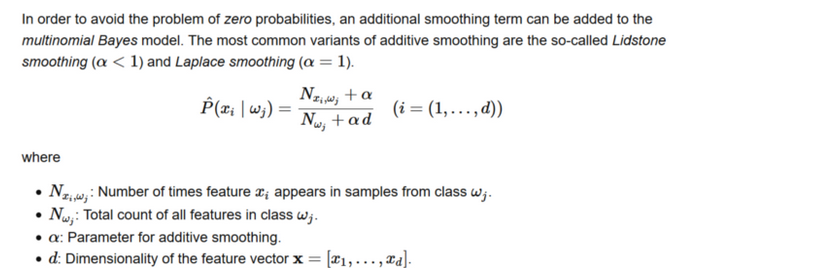

<p dir="rtl">
این مقدار بین حالت empirical = Xi/N و حالت یکنواختD/1  است. اگر آلفا برابر صفر انتخاب شود همان احتمال قبلی حساب می‌شود و اگر بزرگ‌تر از صفر باشد این احتمال هیچ وفت صفر نمی‌شود.


In [82]:
def AddFrequencyOfWords(words,freq_dict):
    global D
    for word in words:
        if not(word in freq_dict):
            freq_dict[word]=1
            D+=1
        else:
            freq_dict[word]+=1
    return freq_dict

def FrequencyCalculator(train):
    for i in range(len(arr_freq)):
        for rec_com_title in train.loc[train['categories']==classes[i],'title']:
            arr_freq[i]=AddFrequencyOfWords(rec_com_title,arr_freq[i])

        for rec_com_description in train.loc[train['categories']==classes[i],'description']:
            arr_freq[i]=AddFrequencyOfWords(rec_com_description,arr_freq[i])

In [83]:
def AdditiveSmoothingProbability(freq,alpha,N):
    return (freq+alpha)/(N+alpha*D)

def Classify(test,alpha):
    probb = [0] * len(arr_freq)
    for i in range(len(test)):
        for f in range(len(arr_freq)):
            prob = log(1/6)
            for w in ['title', 'description']:
                for word in test[w][i]:
                    count = 0
                    if word in arr_freq[f]:
                        count = arr_freq[f][word]
                    new_prob = AdditiveSmoothingProbability(count,alpha,len(arr_freq[f]))
                    if new_prob!= 0:
                        prob+=log(new_prob)
                    else:
                        prob = 0
            probb[f] = prob
        index = probb.index(max(probb))
        predicted_categories.append(classes[index])

<p dir="rtl">
سوال شش:
<p dir="rtl">
نمودارها با توجه به مجموعه داده‌های هر کلاس رسم شده است. در همه کلاس‌ها کلمه‌های کتاب و داستان پرتکرار هستند. می‌توان نتیجه گرفت این کلمه علی الخصوص کتاب تاثیر چندانی در پیش بینی کلاس نخواهد داشت. بنابراین حذف آن‌ها می‌تواند گزینه خوبی باشد.

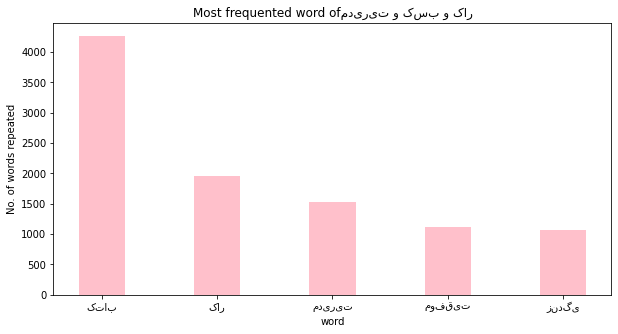

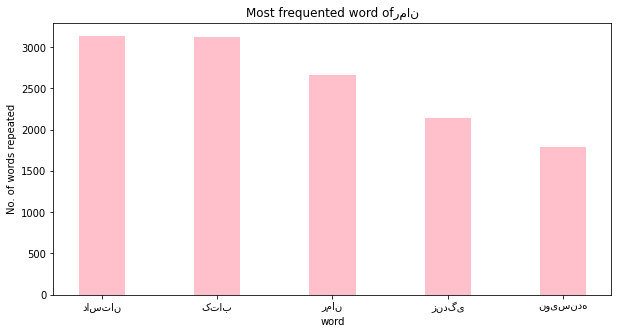

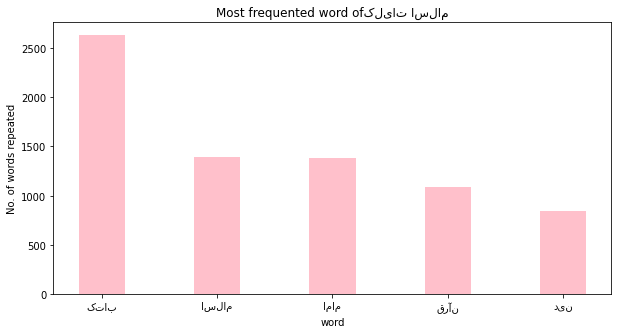

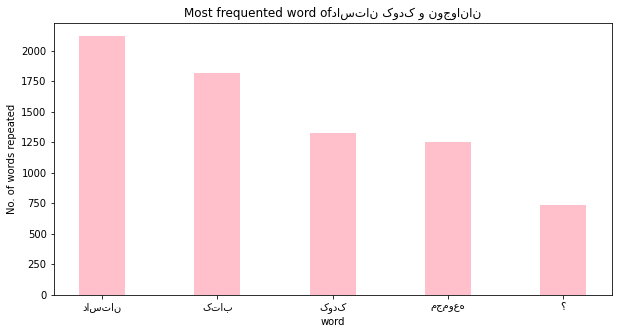

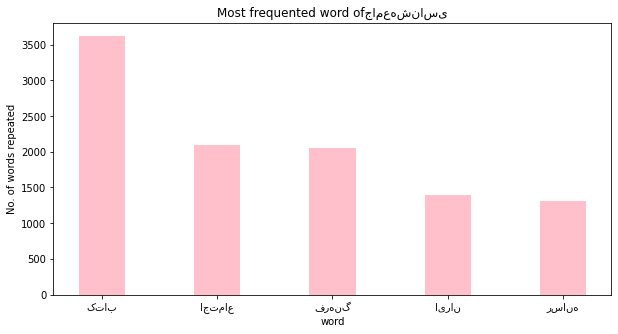

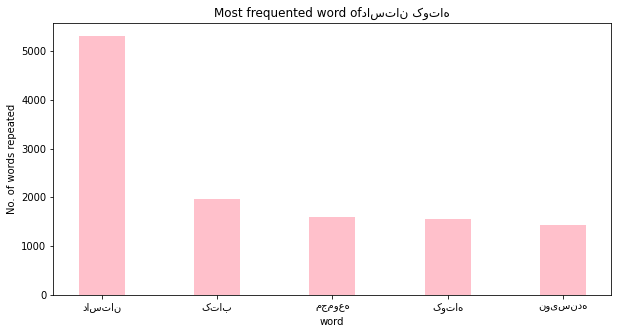

In [91]:
def barPlot(index, freq):
    sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    top = sort_orders[0:5]
    courses = []
    values = []
    for item in top:
        courses.append(item[0])
        values.append(item[1])
    
    plt.figure(figsize = (10, 5))
    plt.bar(courses, values, color ='pink', width = 0.4)

    plt.xlabel("word")
    plt.ylabel("No. of words repeated")
    plt.title("Most frequented word of"+classes[index])
    plt.show()

for f in range(len(arr_freq)):
    barPlot(f, arr_freq[f])

<p dir="rtl">
<b>فاز سوم: ارزیابی</b>

<p dir="rtl">
با استفاده از تابع classify فاز قبل کلاس داده‌های موجود در فایل تست را پیش بینی می‌کنیم و در تابع evaluate با کلاس واقعی خود مقایسه می‌کنیم و پارامترهای ارزیابی را محاسبه می‌نماییم. 

<p dir="rtl">
سوال هفت:
<p dir="rtl">
precision: چه نسبتی از متن‌هایی که جز کلاس c تشخیص داده شده‌اند واقعا جز همین کلاس هستند.
recall: چه نسبتی از متن‌های کلاس ‌c را سیستم درست تشخیص داده است.
precision بسیار بالا به تنهایی کافی نیست. مثلا اگر سیستم ما تنها درصورتی که خیلی مطمئن است که متن جامعه‌شناسی است، آن را جامعه‌شناسی تشخیص دهد، آنگاه precision بالایی خواهیم داشت اما ممکن است متن‌های زیادی به درستی تشخیص داده نشده باشند یا مثلا فقط یک متن را به درستی جامعه‌شناسی تشخیص دهیم و بقیه جز کلاس‌های دیگر بگذاریم.
همچنین recall بالا به تنهایی کافی نیست. مثلا در حالتی که تمام متن‌ها را جامعه‌شناسی تشخیص دهیم، recall بالایی به دست خواهیم آورد درصورتی که می‌دانیم سیستم ما خوب نیست.
هیچ یک از precision و recall به FP و FN همزمان حساس نیست.

<p dir="rtl">
سوال هشت:
<p dir="rtl">
F1 از harmonic mean که نوعی میانگین هندسی است استفاده می‌کند. F1 برخلاف precision و recall همزمان به FP و FN حساس است و معیار مناسبی می‌باشد.

<p dir="rtl">
سوال نه:
<p dir="rtl">
macro:برای macroF1 بین ۶ مقدار به دست آمده از ۶ کلاس مختلف یک میانگین‌گیری انجام می‌دهیم.
<p dir="rtl">
weighted:برحسب تعداد پارامترها برای هر مقدار یک وزن اختصاص می‌دهیم.
تعداد کلاس‌ها را پیدا کنیم و در F1 متناظر خود ضرب می‌کنیم سپس حاصل جمع مقادیر به دست آمده را در تعداد ‌کل تقسیم کنیم.
<p dir="rtl">
micro:تمام داده‌ها را باهم در نظر می‌گیریم و ‌FN , FPها جدا نکنیم پس داریم:
microF1 = microPrecision = microRecall = accuracy

In [85]:
def Evaluate(test):
    correct_detected=0
    total=len(test)
    Precision = [0]* len(classes)
    Recall = [0]* len(classes)
    F1 = [0]* len(classes)
    correct_detected_class = [0]* len(classes)
    all_detected_class = [0]* len(classes)
    total_class = [0]* len(classes)

    counter=0
    X=[]

    for description_counter in range(len(test)):
        if test['categories'][description_counter]==test['predicted categories'][description_counter]:
            correct_detected+=1
        elif counter<5:
            counter+=1
            X.append(description_counter)
        for i in range(len(classes)):
            if test['predicted categories'][description_counter]==classes[i] and test['categories'][description_counter]==classes[i]:
                correct_detected_class[i]+=1
            if test['predicted categories'][description_counter]==classes[i]:
                all_detected_class[i]+=1
            if test['categories'][description_counter]==classes[i]:
                total_class[i]+=1
            
    Accuracy=correct_detected/total*100
    macroF1 = 0
    for i in range(len(classes)):
        Precision[i]=correct_detected_class[i]/all_detected_class[i]*100
        Recall[i]=correct_detected_class[i]/total_class[i]*100
        F1[i]=2*Precision[i]*Recall[i]/(Precision[i]+Recall[i])
        macroF1 += F1[i]
        print(classes[i], ':    Precision=', Precision[i],'   Recall=',Recall[i],'   F1=',F1[i])
    print("Accuracy=", Accuracy)
    print("macroF1=", macroF1/6)
    return X

<p dir="rtl">
سوال ده:
<p dir="rtl">
a) نتایج با استفاده از additive smoothing به قرار زیر است. برای نتیجه بهتر آلفا را برابر ۰/۲ قرار دادم.

In [89]:
start=time.time()
D=0
predicted_categories=[]
FrequencyCalculator(train)
Classify(test_a,alpha=0.2)
test_a['predicted categories']=predicted_categories
print('with Additive Smoothing:')
X = Evaluate(test_a)
print("time=" ,time.time()-start)

with Additive Smoothing:
مدیریت و کسب و کار :    Precision= 87.5    Recall= 93.33333333333333    F1= 90.3225806451613
رمان :    Precision= 60.71428571428571    Recall= 90.66666666666666    F1= 72.72727272727273
کلیات اسلام :    Precision= 91.04477611940298    Recall= 81.33333333333333    F1= 85.91549295774647
داستان کودک و نوجوانان :    Precision= 88.23529411764706    Recall= 80.0    F1= 83.9160839160839
جامعه‌شناسی :    Precision= 79.76190476190477    Recall= 89.33333333333333    F1= 84.27672955974843
داستان کوتاه :    Precision= 82.05128205128204    Recall= 42.66666666666667    F1= 56.140350877192986
Accuracy= 79.55555555555556
macroF1= 78.88308511386764
time= 0.46729159355163574


<p dir="rtl">
سوال دوازده:
<p dir="rtl">
۵ مورد از کتاب‌هایی که اشتباه تشخیص داده شده‌اند به قرار زیر است. مثلا در مورد اول داستان کوتاه است که اشتباهی رمان تشخیص داده است. زیرا کلمات این دو موضوع بسیار مشترک است همچنین کلماتی که در متن کتاب وجود دارد مثل داستان، کتاب، نویسنده و زندگی در مجموعه داده کلاس رمان تکرارشوندگی بیشتری داشته است بنابراین احتمال تعلق به این کلاس بیشتر شده است. برای مثال دوم کلمه اقتصاد در متن پرتکرار بوده است و این کلمه در کلاس جامعه‌شناسی  احتمال بودن بیشتری دارد به این ترتیب این کلمه باعث شده است کلاس این داده اشتباه تشخیص داده شود.
برای سایر اشتباهات دیگر نیز همین اتفاقات مشابه رخ داده است.

In [87]:
for i in X:
  print(i, ":  " ,test_a['title'][i], test_a['description'][i], test_a['categories'][i], test_a['predicted categories'][i],"\n\n\n")

0 :   ['کآشوب'] ['کآشوب', 'بیست', 'روایت', 'روضه', 'زندگی', 'همت', 'نفیسه', 'مرشدزاده', 'جمع\u200cآوری', 'کآشوب', 'روایت', 'واقعی', 'مستند', 'نسل', 'امروز', 'واقعه', 'سال', '۶۱', 'هجری', 'شهادت', 'مظلومانه', 'امام', 'حسین', 'علیه\u200cالسلام', 'نویسندگان', 'شغل', 'گرایش', 'مختلف', 'قرار', 'لحن', 'توصیف', 'زیسته', 'خود', 'مجالس', 'گذشته', 'امروز', 'گزارش', 'دل', 'دست', 'داد#ده', 'این\u200cجا', 'آن\u200cجا', 'شیفتگی', 'متن', 'زد#زن', 'مجموعه', 'ذره', 'مداوم', 'اثر', 'حوزه', 'عاشورا', 'محرم', 'تولید', 'محض', 'تولد', 'هزارانی', 'پیش', 'دوره', 'ساحت', 'واقعه', 'تمام\u200cنشدنی', 'پیشکش', 'شده\u200cاست', 'روایت', 'هفتم', 'فراز', 'تپه', 'علی', 'غبیشاوی', 'شانزده', 'هفده', 'بود#باش', 'ماه', 'تابستان', 'تعطیلات', 'سال', 'نو', 'قم', 'کاشت#کار', 'داشت#دار', 'رفت#رو', 'خوزستان', 'روستا', 'پدر', 'حاج\u200cبابا', 'محرم', 'افتاد#افت', 'تعطیلات', 'محرم', 'قم', 'بود#باش', 'روز', 'داشت#دار', 'اتصال', 'سیم', 'باند', 'حیاط', 'کرد#کن', 'وصله', 'زد#زن', 'داشت#دار', 'میخ', 'درآمده\u200cی', 'پایه', 'عقب', 'من

 <p dir="rtl">
 سوال ده:
 <p dir="rtl">
b) نتایج بدون استفاده از additive smoothing به قرار زیر است. برای بی اثر کردن additive smoothing آلفا را برابر ۰ قرار دادم.

In [90]:
start=time.time()
D=0
predicted_categories=[]
FrequencyCalculator(train)
Classify(test_a,alpha=0)
test_a['predicted categories']=predicted_categories
print('without Additive Smoothing:')
Evaluate(test_a)
print("time=" ,time.time()-start)

without Additive Smoothing:
مدیریت و کسب و کار :    Precision= 7.975460122699387    Recall= 17.333333333333336    F1= 10.92436974789916
رمان :    Precision= 10.0    Recall= 6.666666666666667    F1= 8.0
کلیات اسلام :    Precision= 3.389830508474576    Recall= 2.666666666666667    F1= 2.985074626865672
داستان کودک و نوجوانان :    Precision= 4.2105263157894735    Recall= 5.333333333333334    F1= 4.705882352941177
جامعه‌شناسی :    Precision= 12.903225806451612    Recall= 5.333333333333334    F1= 7.547169811320757
داستان کوتاه :    Precision= 15.384615384615385    Recall= 10.666666666666668    F1= 12.598425196850394
Accuracy= 8.0
macroF1= 7.7934869559795255
time= 0.47559142112731934


<p dir="rtl">
سوال یازده:
<p dir="rtl">
دقت در حالت بدون استفاده از additive smoothing بسیار کمتر است. زیرا احتمال وجود کلمات جدید در متن تست زیاد است و هر چقدر داده‌های train هم وسیع باشد ممکن است وجود حتی یک کلمه احتمال تعلق به کلاسی درست را صفر کند و دقت کم شود. 